# Import des modules

In [0]:
# modules pour le traitement de données
import pandas as pd
import numpy as np

# modules pour les visualisations statiques
import matplotlib.pyplot as plt
import seaborn as sns


# modules pour les visualisations dynamiques (plotly)
import plotly.graph_objects as go
import plotly.express as px

# Import du dataset

* Le dataset comprends les informations de base du film (identifiant, titre, année de sortie, la durée, le genre)
* Le genre retenu est le premier figurant dans la liste des genres dans les données brutes (considéré comme le genre principal du film). 
* Afin d'éviter un hiérarchisation des genres qui pourrait perturber l'algorithme, chaque genre possède sa colonne, pour permettre une identification par booleen (si le film appartient à un genre la valeur est 1 - sinon 0)
* 10 colonnes concernent les votes : elles répartissent les votes par classe d'age et par sexe des votants ; une colonne average_votes permet d'avoir un apercu de la tendance générale des votes
* les 3 dernières colonnes comportent des identifiant qui ont permettent la fusion du tableau de données avec d'autres données)

In [0]:
df_movies = pd.read_csv('https://raw.githubusercontent.com/KoxNoob/Recommandation-Films-WCS/master/df_movies.csv') 
df_movies.drop(['Unnamed: 0'], axis=1, inplace=True) 
df_movies.head(2)

,imdb_title_id,title,year,genre 1,duration,average_votes,allgenders_18age_avg_vote,allgenders_30age_avg_vote,allgenders_45age_avg_vote,males_allages_avg_vote,males_18age_avg_vote,males_30age_avg_vote,males_45age_avg_vote,females_allages_avg_vote,females_18age_avg_vote,females_30age_avg_vote,females_45age_avg_vote,director,actor_1,actor_2,description,g_Action,g_Adult,g_Adventure,g_Animation,g_Biography,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Family,g_Fantasy,g_Film-Noir,g_History,g_Horror,g_Music,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Sport,g_Thriller,g_War,g_Western,imdbId,movieId,tmdbId
0,tt0000574,The Story of the Kelly Gang,1906,Biography,70,6.17,6.2,5.9,6.4,6.1,6.2,5.9,6.4,6.1,5.7,6.0,6.6,Charles Tait,Elizabeth Tait,John Tait,True story of notorious Australian outlaw Ned ...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,574,170573,20105.0
1,tt0002101,Cleopatra,1912,Drama,100,5.00,4.6,5.1,5.3,5.0,4.6,5.1,5.2,5.8,4.5,5.5,6.2,Charles L. Gaskill,Helen Gardner,Pearl Sindelar,The fabled queen of Egypt's affair with Roman ...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2101,170479,71266.0


In [0]:
df_movies.shape

(42200, 47)

# Ajout des données pays au dataset

Pour permettre la visulation sur une carte, les pays de production ont été récupérés - de la même manière que pour le genre, seul le premier mentionné - dans le cas d'une co-production- , considéré  comme le principal a été retenu, pour faciliter la géolocalisation.

Dans un second temps, on importe les données de code iso_alpha_3 (identification des pays par une code alphabétique de 3 lettre) qui permet la géolocolisation sur la carte.

In [0]:
pays = pd.read_csv('https://raw.githubusercontent.com/KoxNoob/Recommandation-Films-WCS/master/df_country.csv')

#fusion avec df_movies
df_movies = df_movies.merge(pays, how='inner', on='imdb_title_id')
df_movies.drop(columns=['Unnamed: 5',	'Unnamed: 6', 	'Unnamed: 7',	'Unnamed: 8', 'year_y',	'duration_y', 'avg_vote'], inplace=True)
df_movies.rename(columns={'year_x' :'year',	'duration_x' : 'duration'}, inplace=True)

#extraction du premier pays
df_movies['country'].fillna(value='unknown', inplace=True)

#nettoyage de la chaise de caractère
c1 = []
for index, value in df_movies['country'].items(): 
  x = value.split(',')
  z = x[0]
  z = z.rstrip(',')
  c1.append(z)

#on crée 2 colonnes : 'country_1' qui sera modifiée pour permettre la correspondance avec les données des codes iso (noms officiels) 
#et 'pays' qui gardera les noms fournis par imdb (noms usuels ou noms de pays n'existant plus)
df_movies['country_1'] = c1
df_movies['pays'] = c1

#données sur les iso alpha 3 pour visualisation carte - on garder les données de latitude et de longitude par précaution
iso_alpha = pd.read_csv('https://gist.githubusercontent.com/tadast/8827699/raw/0d1f2d2524bc2df23c92fe306956935391665b0e/countries_codes_and_coordinates.csv')
iso_alpha = iso_alpha[['Country', 'Alpha-3 code', 'Latitude (average)',	'Longitude (average)']]
iso_alpha = iso_alpha.apply(lambda x : x.str.rstrip('"'))
iso_alpha = iso_alpha.apply(lambda x : x.str.lstrip(' "'))
iso_alpha['Latitude (average)'] = iso_alpha['Latitude (average)'].astype('float')
iso_alpha['Longitude (average)'] = iso_alpha['Longitude (average)'].astype('float')

# nettoyage pour faire coicider les noms des pays dans entre df_movies et iso_alpha
for index, value in df_movies['country_1'].items() :
  if value == 'USA' :
    df_movies['country_1'].iat[index] = 'United States'
  if value == 'UK':
    df_movies['country_1'].iat[index] = 'United Kingdom'
  if value == 'East Germany' or value == 'West Germany':
    df_movies['country_1'].iat[index] = 'Germany'
  if value == 'Soviet Union':
    df_movies['country_1'].iat[index] = 'Russian Federation'
  if value == 'Isle Of Man':
    df_movies['country_1'].iat[index] = 'Isle of Man'
  if value == 'Czechoslovakia':
    df_movies['country_1'].iat[index] = 'Czech Republic'
  if value == 'Iran' :
    df_movies['country_1'].iat[index] = 'Iran, Islamic Republic of'
  if value == 'Palestine':
    df_movies['country_1'].iat[index] = 'Palestinian Territory, Occupied'
  if value == 'Yugoslavia':
    df_movies['country_1'].iat[index] = 'Serbia'
  if value =='The Democratic Republic Of Congo':
    df_movies['country_1'].iat[index] = 'Congo, the Democratic Republic of the'
  if value == 'Federal Republic of Yugoslavia':
    df_movies['country_1'].iat[index]='Montenegro'
  if value =='North Korea':
    df_movies['country_1'].iat[index]="Korea, Democratic People's Republic of"
  if value =='Republic of Macedonia':	
    df_movies['country_1'].iat[index]='Macedonia, the former Yugoslav Republic of'
  if value =='Syria':
    df_movies['country_1'].iat[index]='Syrian Arab Republic'

# fusion avec pays
df_movies = df_movies.merge(iso_alpha, how='left', left_on='country_1', right_on='Country')

# supression du doublon
#df_movies.drop(columns='Country', inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.



In [0]:
# Vérification : les lignes vides concernent les films dont le pays est inconnu 
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42200 entries, 0 to 42199
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   imdb_title_id              42200 non-null  object 
 1   title                      42200 non-null  object 
 2   year                       42200 non-null  int64  
 3   genre 1                    42200 non-null  object 
 4   duration                   42200 non-null  int64  
 5   average_votes              42200 non-null  float64
 6   allgenders_18age_avg_vote  42200 non-null  float64
 7   allgenders_30age_avg_vote  42200 non-null  float64
 8   allgenders_45age_avg_vote  42200 non-null  float64
 9   males_allages_avg_vote     42200 non-null  float64
 10  males_18age_avg_vote       42200 non-null  float64
 11  males_30age_avg_vote       42200 non-null  float64
 12  males_45age_avg_vote       42200 non-null  float64
 13  females_allages_avg_vote   42200 non-null  flo

# Statistiques par film 

## DUREE

Création d'un dataframe intermédiaire - ici un exemple est utilisé


In [0]:
#Durée du film sélectionné
mov_imdb = df_movies[df_movies['title']=='Gone with the Wind']['imdb_title_id'].values[0]
mov_duree = df_movies[df_movies['imdb_title_id']== mov_imdb]['duration'].values[0]


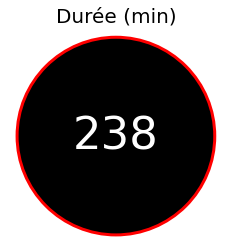

In [0]:
fig, ax = plt.subplots()

x = 0
y = 0

circle = plt.Circle((x, y), radius=1, facecolor='black', edgecolor=(1,0, 0), linewidth=3)

ax.add_patch(circle)

label = ax.annotate(mov_duree, xy=(x, y), fontsize=45, ha="center", va='center', color='white')
plt.title('Durée (min)', fontsize=20, fontdict={'verticalalignment': 'baseline','horizontalalignment': 'center', 'color':'black'})
ax.set_aspect('equal')
ax.autoscale_view()
plt.axis('off')
plt.show()

## TOP 3 Genre et année

In [0]:
#au choix : mov_id (dataframe) ou mov_imdb (avec un exemple)
mov_imdb = df_movies[df_movies['title']=='Gone with the Wind']['imdb_title_id'].values[0]
mov_genre1 = df_movies[df_movies['imdb_title_id'] == mov_imdb]['genre 1'].values[0]

### TOP 3 Année

In [0]:
#dataframe
mov_year = df_movies[df_movies['imdb_title_id'] == mov_imdb]['year'].values[0]
Top_year = df_movies[df_movies['year']==mov_year][['title', 'director', 'average_votes']].sort_values(by='average_votes', ascending=False).head(3).reset_index(drop=True)
Top_year.index = Top_year.index + 1
Top_year.rename(columns={'title' : 'Titre', 'director': 'Réalisateur', 'average_votes' : 'Note'}, inplace=True)


In [0]:
fig = go.Figure(data=[go.Table(columnorder = [1,2, 3, 4],
  columnwidth = [8, 50, 50, 10],
    header=dict(values=['', 'Titre', 'Réalisateur', 'Note'], fill_color='red', line=dict(width=2), font=dict(color='white', size=14)),
    cells=dict(values=[[1, 2, 3], Top_year.Titre, Top_year.Réalisateur, Top_year.Note],
               fill_color=['red','black'],  font=dict(color='white', size=[14,12]), line=dict(width=2),height=30))])

fig.update_layout(width=1200, height=500) 
fig.show()

### TOP 3 Genre

In [0]:
#dataframe
mov_genre1 = df_movies[df_movies['imdb_title_id'] == mov_imdb]['genre 1'].values[0]
Top_genre = df_movies[df_movies['genre 1']==mov_genre1][['title', 'director',  'year', 'average_votes',]].sort_values(by='average_votes', ascending=False).head(3).reset_index(drop=True)
Top_genre.index = Top_genre.index +1
Top_genre.rename(columns={'title' : 'Titre', 'director': 'Réalisateur', 'year' : 'Année', 'average_votes' : 'Note'}, inplace=True)

In [0]:
fig = go.Figure(data=[go.Table(columnorder = [1,2, 3, 4, 5],
  columnwidth = [8, 50, 50, 20, 10],
    header=dict(values=['', 'Titre', 'Réalisateur', 'Année', 'Note'], fill_color='red', line=dict(width=2), font=dict(color='white', size=14)),
    cells=dict(values=[[1, 2, 3], Top_genre.Titre, Top_genre.Réalisateur, Top_genre.Année, Top_genre.Note],
               fill_color=['red', 'black'], line=dict(width=2), font=dict(color='white'), height=30))])

fig.update_layout(width=1200, height=500) 
fig.show()

## Notes du film sélectionné (par tranche d'age et par sexe)

In [0]:
m_18 = df_movies[df_movies['title']=='Gone with the Wind']['males_18age_avg_vote'].values[0]
m_30 = df_movies[df_movies['title']=='Gone with the Wind']['males_30age_avg_vote'].values[0]
m_45 = df_movies[df_movies['title']=='Gone with the Wind']['males_45age_avg_vote'].values.astype(int)[0]

f_18 = df_movies[df_movies['title']=='Gone with the Wind']['females_18age_avg_vote'].values[0]
f_30 = df_movies[df_movies['title']=='Gone with the Wind']['females_30age_avg_vote'].values[0]
f_45 = df_movies[df_movies['title']=='Gone with the Wind']['females_45age_avg_vote'].values[0]

avg = df_movies[df_movies['title']=='Gone with the Wind']['average_votes'].values[0]

In [0]:
import plotly.graph_objects as go
labels = ['18-30', '30-45', '45 +']
men_means = [m_18, m_30, m_45]
women_means = [f_18, f_30, f_45]

fig = go.Figure(data=[
    go.Bar(name='Hommes', x=labels, y=men_means, marker_color='white', text=men_means,textposition='outside'),
    go.Bar(name='Femmes', x=labels, y=women_means, marker_color='red', text=women_means,textposition='outside')
])

fig.update_layout(template="plotly_dark",title_text='Note moyennne en fonction du genre et de la classe d\'âge', title={'y':0.9,'x':0.5,'xanchor': 'center', 'yanchor': 'top'})

# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(range=[0, 10])
fig.show()

# Statistiques générales

## Pie chart par genre

Le choix a été fait de réprésentaé la distribution des films par genre avec 2 pie charts : 
* un principal avec les genre dont le nombre de films est supérieur à 1000 - qui comprend une catégorie 'divers' 
* un secondaire avec les films moins réprésentés dans le premier pie chart, qui décrit les genres contenu dans la part 'divers'.

In [0]:
movies_genre= pd.DataFrame(df_movies.groupby(['genre 1'])['imdb_title_id'].count()).reset_index()
movies_genre.rename(columns={'genre 1' : 'Genre', 'imdb_title_id' :'Nombre de films'}, inplace=True)
movies_genre['Sous_genre'] = movies_genre['Genre'] 
movies_genre.loc[movies_genre['Nombre de films'] < 1000, 'Genre'] = "Divers"
#movies_genre

In [0]:
fig = px.pie(movies_genre, values='Nombre de films', names='Genre', title='Répartition des films par genre', 
             color_discrete_sequence=px.colors.sequential.Reds_r, template="plotly_dark")
fig.update_layout(title={'y':0.9,'x':0.5,'xanchor': 'center', 'yanchor': 'top'}, showlegend=False)
fig.update_traces(textposition='inside', textinfo='label+percent')
fig.show()

In [0]:
fig = px.pie(movies_genre[movies_genre['Genre']=='Divers'], values='Nombre de films', names='Sous_genre', title='Répartition des genres dans les films classés "Divers"', 
             color_discrete_sequence=px.colors.sequential.Reds_r, template="plotly_dark")
fig.update_layout(title={'y':0.9,'x':0.5,'xanchor': 'center', 'yanchor': 'top'}, showlegend=False)
fig.update_traces(textposition='inside', textinfo='label+percent')
fig.show()

## Bar chart : Films par année

In [0]:
#dataframe nombre de films par an
moviesByYear = pd.DataFrame(df_movies.groupby(['year'])['imdb_title_id'].count())
moviesByYear.reset_index(inplace=True)
moviesByYear.rename(columns={'year' : 'Année', 'imdb_title_id' :'Nombre de films'},inplace=True)

In [0]:
fig = px.bar(moviesByYear, x='Année', y='Nombre de films', template="plotly_dark", title='Evolution de la production cinématographique annuelle')
fig.update_traces(marker_color='red')
fig.update_layout(title={'y':0.9,'x':0.5,'xanchor': 'center', 'yanchor': 'top', 'font' :  {'size' : 24}}, yaxis_title="nombre de films", xaxis_title="")

fig.show()

### Map (visualisation 3D)

Une 'bubble map' plotly a été choisie pour la représentation 3D. Elle offre un rendu dynamique et esthétique pour permettre une vision rapide de la répartition mondiale de la production de films.



In [0]:
# df avec le nombre de film par pays (pays, code iso, nombre defilm(count)
moviesByCountry = pd.DataFrame(df_movies.groupby(['Alpha-3 code', 'pays'])['imdb_title_id'].count())
moviesByCountry.rename(columns={'imdb_title_id' :'Nombre de films'},inplace=True)
moviesByCountry.reset_index(inplace=True)
#moviesByCountry

In [0]:
fig = px.scatter_geo(moviesByCountry, title='Production cinématographique mondiale', locations="Alpha-3 code", 
                      size="Nombre de films", size_max=60, template="plotly_dark", hover_name="pays",
                     projection="orthographic")

fig.update_layout(title={'y':0.95,'x':0.5,'xanchor': 'center', 'yanchor': 'top'}, showlegend = True, width=600, height=600, font=dict(color='white', size=18))

fig.update_geos(showcountries=True, countrycolor="#292929", coastlinecolor="grey")

fig.update_traces(marker=dict(color='red'))
fig.show()